## Assignment 1 - Machine Learning Project
### Project 1: Classify Images of Colon Cancer
##### Group No. 3: Sheikh Abdul Munim (s4076159), Liya Benoy (s4027344)

In [63]:
#importing required libraries
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

In [64]:
main_data = pd.read_csv("Image_classification_data\data_labels_mainData.csv")
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [65]:
class ColonCancerPatchServer:
    def __init__(self, main_data_path, extra_data_path, image_folder):
        self.main_df = pd.read_csv(main_data_path)
        self.extra_df = pd.read_csv(extra_data_path)
        self.image_folder = image_folder

        # Merge both datasets and track source
        self.main_df["source"] = "main"
        self.extra_df["source"] = "extra"
        self.data = pd.concat([self.main_df, self.extra_df], ignore_index=True)
        self.data["ImagePath"] = self.data["ImageName"].apply(lambda x: os.path.join(image_folder, x))

    def __len__(self):
        return len(self.data)

    def get_image(self, idx, target_size=(64, 64), normalize=True):
        image_path = self.data.iloc[idx]["ImagePath"]
        try:
            img = Image.open(image_path).convert("RGB").resize(target_size)
            img_array = np.array(img)
            if normalize:
                img_array = img_array / 255.0
            return img_array
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None

    def get_labels(self, idx):
        row = self.data.iloc[idx]
        is_cancerous = int(row["isCancerous"])
        cell_type = row.get("cellTypeName", None)
        return is_cancerous, cell_type

    def get_sample(self, idx, target_size=(64, 64), normalize=True):
        image = self.get_image(idx, target_size, normalize)
        is_cancerous, cell_type = self.get_labels(idx)
        return image, is_cancerous, cell_type

    def get_data_split(self, label_type="isCancerous"):
        """
        Get data suitable for training/testing
        label_type: "isCancerous" or "cellTypeName"
        """
        X, y = [], []
        for idx in range(len(self.data)):
            image = self.get_image(idx)
            label = self.data.iloc[idx][label_type]
            if pd.isna(label) or image is None:
                continue
            X.append(image)
            y.append(label)
        return np.array(X), np.array(y)

In [66]:
# Initialize server
server = ColonCancerPatchServer(
    main_data_path="Image_classification_data\data_labels_mainData.csv",
    extra_data_path="Image_classification_data\data_labels_extraData.csv",
    image_folder="Image_classification_data\patch_images"
)

# Get a single sample
img, cancer_label, cell_type = server.get_sample(0)
print(img.shape, cancer_label, cell_type)

(64, 64, 3) 0 fibroblast


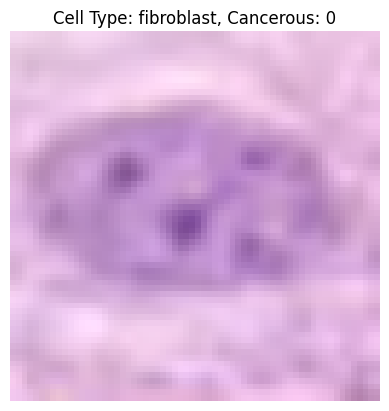

In [67]:
# Load sample image from index 0
image, is_cancerous, cell_type = server.get_sample(0)

# Plot the image
plt.imshow(image)
plt.title(f"Cell Type: {cell_type}, Cancerous: {is_cancerous}")
plt.axis("off")
plt.show()

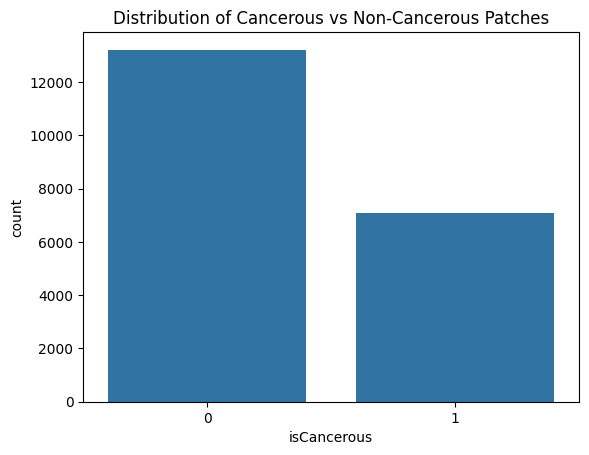

In [68]:
#distribution of 'isCancerous' label
sns.countplot(x='isCancerous', data=server.data)
plt.title('Distribution of Cancerous vs Non-Cancerous Patches')
plt.show()

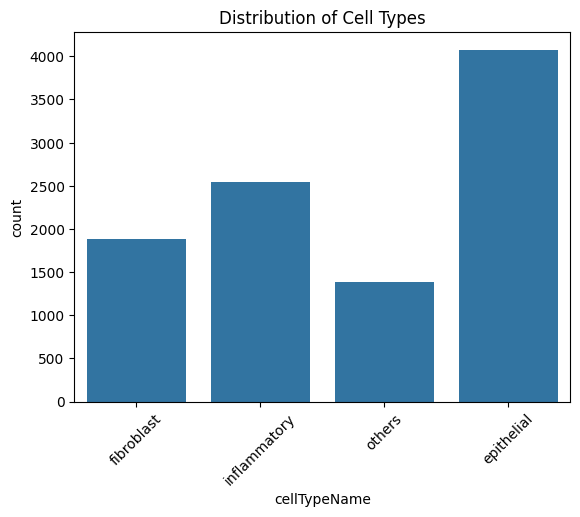

In [69]:
#distribution of 'cellTypeName' label
sns.countplot(x='cellTypeName', data=server.data)
plt.xticks(rotation=45)
plt.title('Distribution of Cell Types')
plt.show()

In [70]:
#checking for missing values within the server
print(server.data.isnull().sum())

InstanceID          0
patientID           0
ImageName           0
cellTypeName    10384
cellType        10384
isCancerous         0
source              0
ImagePath           0
dtype: int64


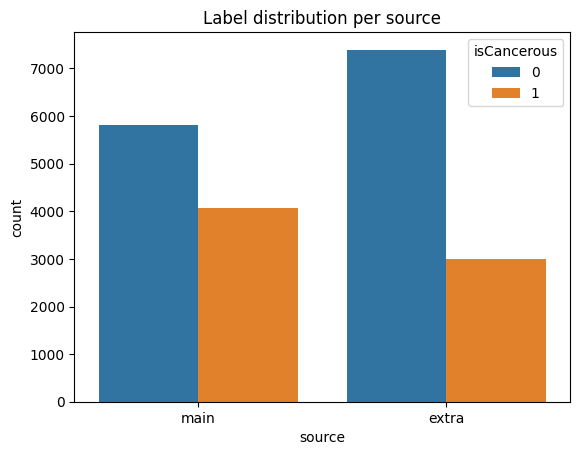

In [71]:
sns.countplot(x='source', hue='isCancerous', data=server.data)
plt.title('Label distribution per source')
plt.show()

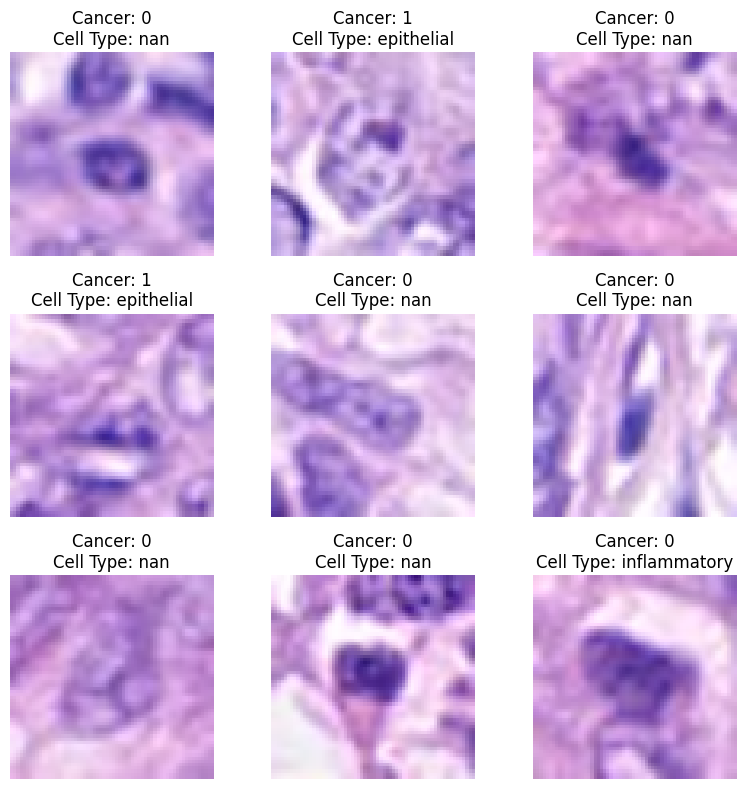

In [72]:
#few sample visualisations (cancerous vs. non-cancerous)
fig, axes = plt.subplots(3, 3, figsize=(8,8))
for ax in axes.flatten():
    idx = random.randint(0, len(server.data) - 1)
    img, label, cell_type = server.get_sample(idx)
    ax.imshow(img)
    ax.set_title(f"Cancer: {label}\nCell Type: {cell_type}")
    ax.axis('off')
plt.tight_layout()
plt.show()

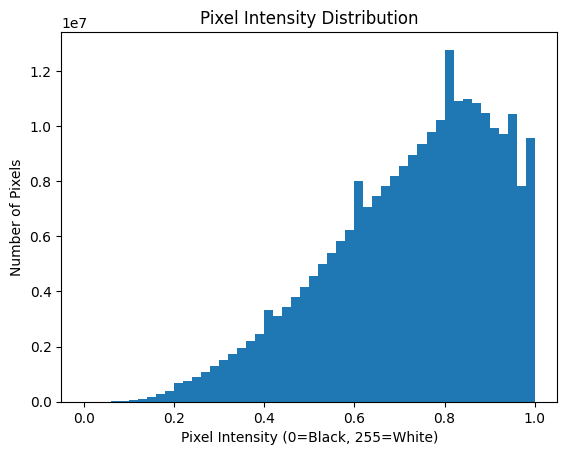

In [73]:
#plotting pixel intensity distribution across cell images
X, y = server.get_data_split()
plt.hist(X.ravel(), bins=50)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity (0=Black, 255=White)')
plt.ylabel('Number of Pixels')
plt.show()

In [74]:
#checking for any images that have not loaded onto server
broken_images = []
for idx, path in enumerate(server.data["ImagePath"]):
    try:
        img = Image.open(path)
    except:
        broken_images.append(path)
print(f"Number of broken images: {len(broken_images)}")

Number of broken images: 0


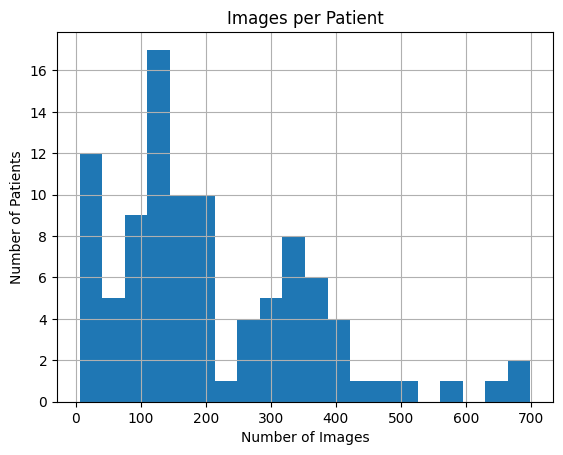

In [75]:
#patient distribution
patient_counts = server.data["patientID"].value_counts()
patient_counts.hist(bins=20)
plt.title("Images per Patient")
plt.xlabel("Number of Images")
plt.ylabel("Number of Patients")
plt.show()

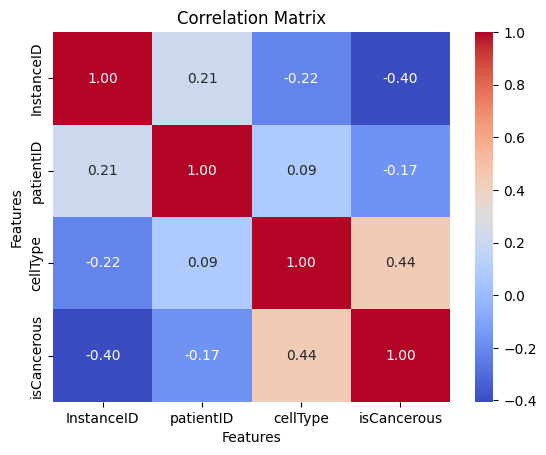

In [76]:
#plotting correlation matrix (heatmap) for numerical features
corr = server.data.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

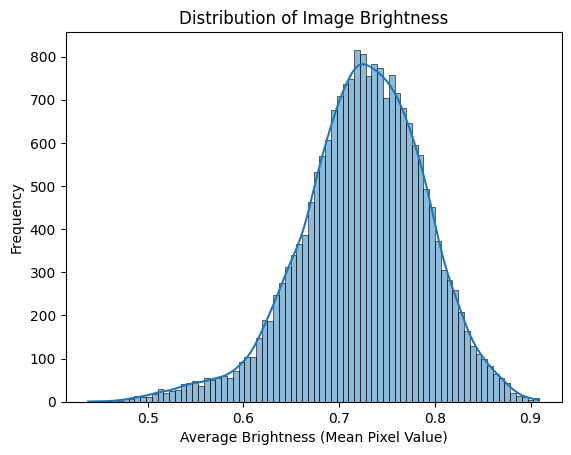

In [77]:
#checking for too bright or too dark images
brightness = []
for idx in range(len(server.data)):
    img = server.get_image(idx)
    if img is not None:
        brightness.append(np.mean(img))

sns.histplot(brightness, kde=True)
plt.title("Distribution of Image Brightness")
plt.xlabel("Average Brightness (Mean Pixel Value)")
plt.ylabel("Frequency")
plt.show()